<a href="https://colab.research.google.com/github/ElenaVillano/sentiment_analysis_tweets/blob/main/notebooks/modelo_ejemplo_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install "git+https://github.com/ElenaVillano/sentiment_analysis_tweets.git#egg=nlptweet&subdirectory=src" --quiet

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import nltk
#import re
import timeit
import string
# Nuestro paquete
import nlp


#call the nltk downloader
nltk.download('punkt')

from dateutil import parser

# Carga un set de stopwords predefinidas
from nltk.corpus import stopwords

from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem import PorterStemmer
from nltk.stem import LancasterStemmer

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [3]:
# Nombramiento de columnas
col_names = ['target', # Polaridad del twet 0=negativo, 2=neutral, 4=positivo
             'ids',    # ID tweet
             'date',   # Fecha y hora del tweet
             'flag',   # QUERY
             'user',   # Usuario del tweet
             'text']   # Texto del tweety

## Cargamos datos limpios

In [4]:
# Requiered to select a file to be imported into colab
# Not useful if running locally
from google.colab import files
uploaded = files.upload()

Saving 1600000_datos_limpios_sin_user_ni_url.csv to 1600000_datos_limpios_sin_user_ni_url.csv


In [41]:
data =  pd.read_csv('1600000_datos_limpios_sin_user_ni_url.csv',
                 encoding='latin-1')

In [42]:
data = data[data.text.notna()]

## TOKENIZER

In [7]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import regularizers

In [43]:
# Entrena un Tokenizer. Consiste en:
# Crea un diccionario numerado de las palabras existentes en el corpus, y devuelve
# por cada palabra, el número entero de su índice en el diccionario.
# En este caso, considera las N palabras más frecuentes.
# oov_token = constante asiganda para palabras fuera del vocabulario (NOT USED HERE)
data_set_1 = data
data_set_1.shape
data_set_1.text

0               aww bummer shoulda got david carr third day 
1          upset updat facebook text might cri result sch...
2          dive mani time ball manag save 50 % rest go bo...
3                           whole bodi feel itchi like fire 
4                                             behav mad see 
                                 ...                        
1599995                          woke school best feel ever 
1599996              thewdbcom cool hear old walt interview 
1599997                        readi mojo makeov ask detail 
1599998     happi 38th birthday boo time tupac amaru shakur 
1599999                                               happi 
Name: text, Length: 1591506, dtype: object

In [10]:
max_words = 1000

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(data_set_1.text)

In [11]:
palabras = pd.DataFrame([(word,count) for i, (word, count) in enumerate(tokenizer.word_counts.items())])

In [12]:
palabras = palabras.sort_values(1,ascending=False).reset_index()[2:]

In [13]:
palabras_mas_frecuentes = palabras.head(500)

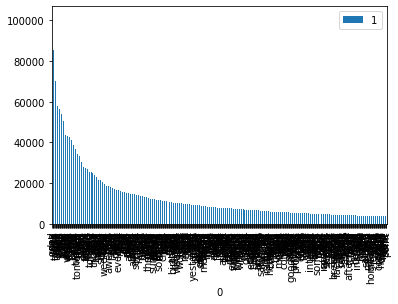

In [14]:
palabras_mas_frecuentes.plot.bar(x=0,y=1)

Elegimos el número de palabras y longitud del vector:

In [15]:
palabras_mas_frecuentes

,index,0,1
2,7,day,101871
3,188,good,92467
4,164,work,85412
5,33,like,83062
6,100,love,81877
...,...,...,...
497,1821,water,3670
498,1079,bout,3663
499,690,star,3655
500,1647,store,3652


In [44]:
# Convierte palabras en enteros
sequences = tokenizer.texts_to_sequences(data_set_1.text)
lengths = []
for seq in sequences:
  lengths.append(len(seq))

print("Tweet más pequeño", np.array(lengths).min(), "words.")
print("Tweet más grande", np.array(lengths).max(), "words.")
print(f"Longitud promedio: {np.array(lengths).mean():.2f} +- {np.array(lengths).std():.2f} words.")
print('\n')

for seq in sequences[:10]:
  print(seq)

Tweet más pequeño 0 words.
Tweet más grande 27 words.
Longitud promedio: 4.96 +- 3.04 words.


[110, 8, 697, 3]
[592, 222, 430, 353, 201, 242, 965, 76, 9, 188]
[221, 10, 860, 686, 495, 344, 1]
[327, 645, 19, 6, 863]
[454, 18]
[327]
[25, 461]
[83, 96, 10, 18, 90, 97, 168, 168, 16, 418, 11]
[656]
[]


In [45]:
train_seq = np.array(sequences, dtype=object)
df_sequences = pd.DataFrame(train_seq.T, columns=['tokens'])

In [46]:
df_sequences['len'] = df_sequences['tokens'].map(lambda s: len(s))

In [47]:
data = data.reset_index().drop(['index', 'Unnamed: 0'], axis = 1)

In [48]:
df_sequences['target'] = data['target']

In [49]:
df_select = df_sequences[(df_sequences.len>3) & (df_sequences.len<9)]

In [50]:
df_select.groupby('target').count()

,tokens,len
target,,
0,397737,397737
1,379250,379250


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


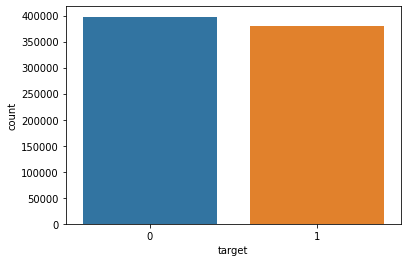

In [51]:
sns.countplot(df_select['target'])

In [53]:
last_df = pd.concat([df_select[df_select.target==0].head(379250),df_select[df_select.target==1]], axis=0)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


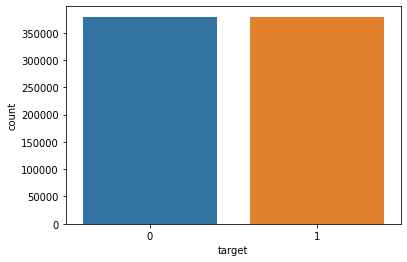

In [54]:
# Revisamos si estan balanceadas las etiquetas
sns.countplot(last_df['target'])

In [55]:
last_df = last_df.sample(n=100000,random_state=21239)

In [56]:
last_df

,tokens,len,target
427630,"[205, 456, 667, 1, 244, 129, 171, 131]",8,0
53106,"[48, 2, 333, 82]",4,0
1366786,"[162, 20, 209, 274, 409, 102, 365, 18]",8,1
1179432,"[34, 231, 798, 631, 376]",5,1
506260,"[449, 28, 84, 108, 115]",5,0
...,...,...,...
445878,"[208, 55, 58, 1, 144, 6]",6,0
514241,"[29, 454, 77, 27, 20, 6]",6,0
927297,"[140, 14, 40, 13, 81, 57]",6,1
904209,"[161, 30, 142, 728, 57]",5,1


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


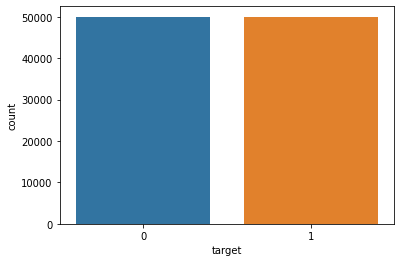

In [57]:
# Revisamos si estan balanceadas las etiquetas
sns.countplot(last_df['target'])

In [60]:
#sequences = tokenizer.texts_to_sequences(data_set_1.text)
max_len = 9
tweets = pad_sequences(list(last_df.tokens), maxlen=max_len, padding='post')
print(tweets)

[[205 456 667 ... 171 131   0]
 [ 48   2 333 ...   0   0   0]
 [162  20 209 ... 365  18   0]
 ...
 [140  14  40 ...   0   0   0]
 [161  30 142 ...   0   0   0]
 [ 21  59 364 ... 305   0   0]]


## Separación de datos en train y test

In [61]:
from sklearn.model_selection import train_test_split

In [62]:
X_train, X_test, y_train, y_test = train_test_split(tweets, last_df.target.values, test_size=0.3, random_state=23042021)

In [63]:
print("X_train", X_train.shape)
print("y_train", y_train.shape)
print("X_test", X_test.shape)
print("y_test", y_test.shape)

X_train (70000, 9)
y_train (70000,)
X_test (30000, 9)
y_test (30000,)


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


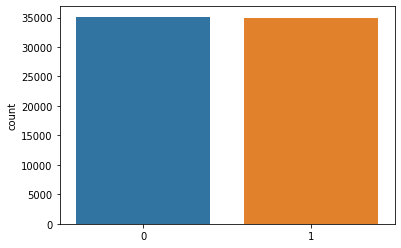

In [64]:
sns.countplot(y_train)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


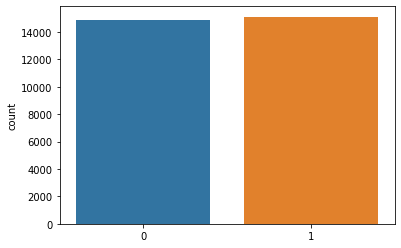

In [65]:
sns.countplot(y_test)

## Modelo 1

In [66]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.regularizers import l1

In [67]:
# Crea una red con layers Embedding, LSTM, Dense
model = Sequential()
model.add(Embedding(input_length=max_len, input_dim=max_words, output_dim=64, trainable=True))
model.add(Bidirectional(LSTM(units=64)))
model.add(Dropout(0.5))
model.add(Dense(units=16, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(units=1, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 9, 64)             64000     
_________________________________________________________________
bidirectional (Bidirectional (None, 128)               66048     
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 16)                2064      
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 132,129
Trainable params: 132,129
Non-trainable params: 0
__________________________________________________

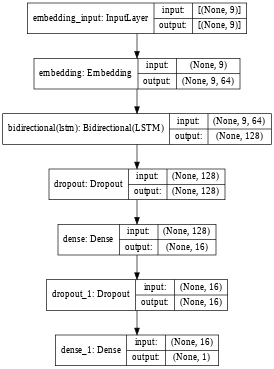

In [68]:
# Plot model
from tensorflow.keras.utils import plot_model
plot_model(model, show_shapes=True, show_layer_names=True,
                          rankdir='TB', expand_nested=True, dpi=48)

In [69]:
# Compile
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=False), optimizer='adam', 
              metrics=[tf.metrics.BinaryAccuracy(), 'accuracy'])

In [73]:
#%%timeit

# Train it
history_1 = model.fit(X_train, y_train, epochs=20, batch_size=16, validation_split=0.2)

Epoch 1/20
3500/3500 [==============================] - 31s 9ms/step - loss: 0.1039 - binary_accuracy: 0.9627 - accuracy: 0.9627 - val_loss: 2.2084 - val_binary_accuracy: 0.6819 - val_accuracy: 0.6819
Epoch 2/20
3500/3500 [==============================] - 31s 9ms/step - loss: 0.1004 - binary_accuracy: 0.9641 - accuracy: 0.9641 - val_loss: 2.2565 - val_binary_accuracy: 0.6795 - val_accuracy: 0.6795
Epoch 3/20
3500/3500 [==============================] - 31s 9ms/step - loss: 0.0969 - binary_accuracy: 0.9665 - accuracy: 0.9665 - val_loss: 2.1655 - val_binary_accuracy: 0.6856 - val_accuracy: 0.6856
Epoch 4/20
3500/3500 [==============================] - 31s 9ms/step - loss: 0.0926 - binary_accuracy: 0.9672 - accuracy: 0.9672 - val_loss: 2.2593 - val_binary_accuracy: 0.6815 - val_accuracy: 0.6815
Epoch 5/20
3500/3500 [==============================] - 32s 9ms/step - loss: 0.0909 - binary_accuracy: 0.9688 - accuracy: 0.9688 - val_loss: 2.2132 - val_binary_accuracy: 0.6798 - val_accuracy: 0.

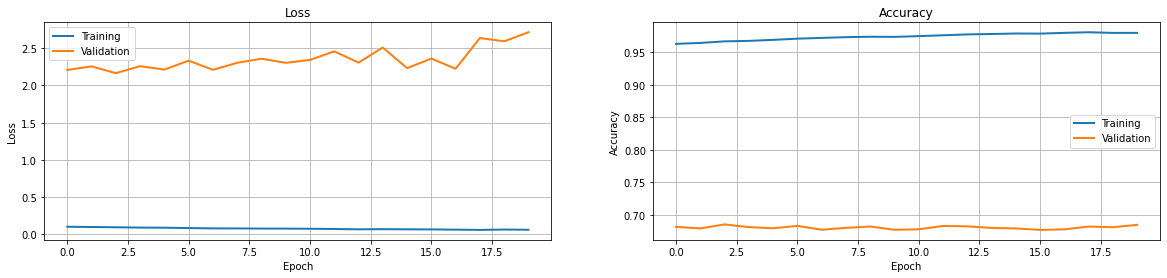

In [76]:
# Plot loss
plt.figure(figsize=(20, 4))

plt.subplot(1, 2, 1)
plt.title('Loss')
plt.plot(history_1.history['loss'], label='Training', linewidth=2)
plt.plot(history_1.history['val_loss'], label='Validation', linewidth=2)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.title('Accuracy')
plt.plot(history_1.history['accuracy'], label='Training', linewidth=2)
plt.plot(history_1.history['val_accuracy'], label='Validation', linewidth=2)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)

plt.show()

In [77]:
# Evaluate on test set
model.evaluate(x=X_test, y=y_test)

938/938 [==============================] - 4s 4ms/step - loss: 2.6647 - binary_accuracy: 0.6903 - accuracy: 0.6903


[2.6646647453308105, 0.6903333067893982, 0.6903333067893982]

# Modelo 2


In [ ]:
# Crea una red con layers Embedding, LSTM, Dense
model = Sequential()
model.add(Embedding(input_length=max_len, input_dim=max_words, output_dim=64, trainable=True))
model.add(LSTM(units=64))
model.add(Dropout(0.5))
model.add(Dense(units=32, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(units=16, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(units=1, activation='sigmoid'))

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 21, 64)            64000     
_________________________________________________________________
lstm_3 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dropout_6 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 32)                2080      
_________________________________________________________________
dropout_7 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 16)                528       
_________________________________________________________________
dropout_8 (Dropout)          (None, 16)               

In [ ]:
# Compile
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), optimizer='adam', metrics=[tf.metrics.BinaryAccuracy(), 'accuracy'])

In [ ]:
history_1 = model.fit(X_train, y_train, epochs=20, batch_size=16, validation_split=0.2)

Epoch 1/20
3500/3500 [==============================] - 45s 12ms/step - loss: 0.6164 - binary_accuracy: 0.6450 - accuracy: 0.6450 - val_loss: 0.5176 - val_binary_accuracy: 0.7418 - val_accuracy: 0.7418
Epoch 2/20
3500/3500 [==============================] - 43s 12ms/step - loss: 0.5330 - binary_accuracy: 0.7445 - accuracy: 0.7445 - val_loss: 0.5156 - val_binary_accuracy: 0.7434 - val_accuracy: 0.7434
Epoch 3/20
3500/3500 [==============================] - 43s 12ms/step - loss: 0.5188 - binary_accuracy: 0.7482 - accuracy: 0.7482 - val_loss: 0.5139 - val_binary_accuracy: 0.7454 - val_accuracy: 0.7454
Epoch 4/20
3500/3500 [==============================] - 43s 12ms/step - loss: 0.5104 - binary_accuracy: 0.7555 - accuracy: 0.7555 - val_loss: 0.5183 - val_binary_accuracy: 0.7426 - val_accuracy: 0.7426
Epoch 5/20
3500/3500 [==============================] - 44s 12ms/step - loss: 0.5062 - binary_accuracy: 0.7604 - accuracy: 0.7604 - val_loss: 0.5160 - val_binary_accuracy: 0.7430 - val_accurac

In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), optimizer='adam', metrics=[tf.metrics.BinaryAccuracy(), 'accuracy'])

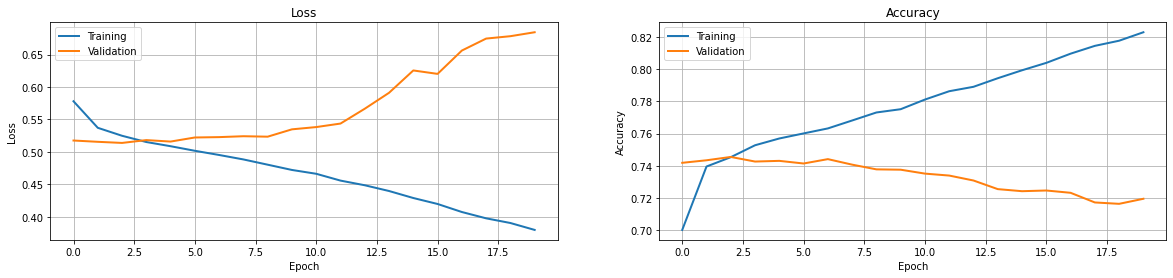

In [ ]:
# Plot loss
plt.figure(figsize=(20, 4))

plt.subplot(1, 2, 1)
plt.title('Loss')
plt.plot(history_1.history['loss'], label='Training', linewidth=2)
plt.plot(history_1.history['val_loss'], label='Validation', linewidth=2)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.title('Accuracy')
plt.plot(history_1.history['accuracy'], label='Training', linewidth=2)
plt.plot(history_1.history['val_accuracy'], label='Validation', linewidth=2)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)

plt.show()

In [ ]:
model.evaluate(x=X_test, y=y_test)

938/938 [==============================] - 5s 4ms/step - loss: 0.6918 - binary_accuracy: 0.7219 - accuracy: 0.7219


[0.697664201259613, 0.7202000021934509, 0.7202000021934509]